In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        df = file.read()
        file.close()
        return df

In [3]:
data = read_text('fra.txt')

After reading the text, the next step is to clean the text before presenting it before the machine

In [4]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [5]:
data = to_lines(data)

In [6]:
data

[['Go.',
  'Va !',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
 ['Go.',
  'Marche.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
 ['Go.',
  'Bouge !',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
 ['Hi.',
  'Salut !',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'],
 ['Hi.',
  'Salut.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)'],
 ['Run!',
  'Cours\u202f!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)'],
 ['Run!',
  'Courez\u202f!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)'],
 ['Run!',
  'Prenez vos jambes à vos cous !',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)'],
 ['Run!',
  'File !',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papab

In [7]:
data = array(data)

In [8]:
data = data[:, :2]
data

array([['Go.', 'Va !'],
       ['Go.', 'Marche.'],
       ['Go.', 'Bouge !'],
       ...,
       ["Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.",
        "La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie."],
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        "Puisqu'il y a de multiples sites web sur chaque sujet, je clique d'habitude sur le bouton retour arrière lorsque j'atterris sur n'importe quelle p

Removing the punctuation marks and symbols


In [9]:
data[:, 0] = [re.sub('[^a-zA-Z\s]' , '', s) for s in data[:, 0]]
data[:, 1] = [re.sub('[^a-zA-Z\s]' , '', s) for s in data[:, 1]]

In [10]:
data

array([['Go', 'Va '],
       ['Go', 'Marche'],
       ['Go', 'Bouge '],
       ...,
       ['Death is something that were often discouraged to talk about or even think about but Ive realized that preparing for death is one of the most empowering things you can do Thinking about death clarifies your life',
        'La mort est une chose quon nous dcourage souvent de discuter ou mme de penser mais jai pris conscience que se prparer  la mort est lune des choses que nous puissions faire qui nous investit le plus de responsabilit Rflchir  la mort clarifie notre vie'],
       ['Since there are usually multiple websites on any given topic I usually just click the back button when I arrive on any webpage that has popup advertising I just go to the next page found by Google and hope for something less irritating',
        'Puisquil y a de multiples sites web sur chaque sujet je clique dhabitude sur le bouton retour arrire lorsque jatterris sur nimporte quelle page qui contient des publicits sur

In [11]:
#converting the text to lower case

for i in range(len(data)):
  data[i, 0] = data[i, 0].lower()
  data[i, 1] = data[i, 1].lower()

In [12]:
data[:, 0] = [s.strip() for s in data[:, 0]]
data[:, 1] = [s.strip() for s in data[:, 1]]

data

array([['go', 'va'],
       ['go', 'marche'],
       ['go', 'bouge'],
       ...,
       ['death is something that were often discouraged to talk about or even think about but ive realized that preparing for death is one of the most empowering things you can do thinking about death clarifies your life',
        'la mort est une chose quon nous dcourage souvent de discuter ou mme de penser mais jai pris conscience que se prparer  la mort est lune des choses que nous puissions faire qui nous investit le plus de responsabilit rflchir  la mort clarifie notre vie'],
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'puisquil y a de multiples sites web sur chaque sujet je clique dhabitude sur le bouton retour arrire lorsque jatterris sur nimporte quelle page qui contient des publicits surgi

In [13]:
data.shape

(185583, 2)

In [14]:
data = data[:50000, :]

#Text to Sequene conversion

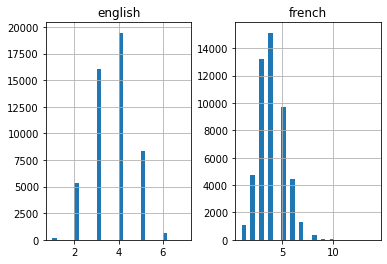

In [15]:
# empty lists
english = []
french = []

# populate the lists with sentence lengths
for i in data[:,0]:
      english.append(len(i.split()))

for i in data[:,1]:
      french.append(len(i.split()))

length_df = pd.DataFrame({'english':english, 'french':french})

length_df.hist(bins = 30)
plt.show()

In [16]:
count = []
for i in english:
  count.append(i)
print(max(count))

7


The maximum sentence length of english sentence is 7 whereas that of french sentence is 12.

Next, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.


In [17]:
def token(file):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(file)
  return tokenizer

In [18]:
# prepare english tokenizer
eng_token = token(data[:, 0])
eng_vocab_size = len(eng_token.word_index) + 1

eng_length = 12
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 5988


In [19]:
# prepare french tokenizer
fre_token = token(data[:, 1])
fre_vocab_size = len(fre_token.word_index) + 1

fre_length = 12
print('French Vocabulary Size: %d' % fre_vocab_size)

French Vocabulary Size: 12335


The below code block contains a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

#MODEL BUILDING

In [21]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(data, test_size=0.2, random_state = 12)

In [22]:
# prepare training data
trainX = encode_sequences(fre_token, fre_length, train[:, 1])
trainY = encode_sequences(eng_token, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fre_token, fre_length, test[:, 1])
testY = encode_sequences(eng_token, eng_length, test[:, 0])

# We’ll start off by defining our Seq2Seq model architecture:










For the encoder, we will use an embedding layer and an LSTM layer.

For the decoder, we will use another LSTM layer followed by a dense layer

In [23]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.

In [24]:
# model compilation
model = define_model(fre_vocab_size, eng_vocab_size, fre_length, eng_length, 512)

In [25]:
rms = optimizers.RMSprop(lr=0.002)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


I've used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.


We are all set to start training our model!

We will train it for 15 epochs and with a batch size of 512 with a validation split of 20%. 80% of the data will be used for training the model and the rest for evaluating it. You may change and play around with these hyperparameters.

We will also use the ModelCheckpoint() function to save the model with the lowest validation loss. I personally prefer this method over early stopping.



#ModelCheckpoint 
callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

##Arguments

###filepath: 
string or PathLike, path to save the model file. e.g. filepath = os.path.join(working_dir, 'ckpt', file_name). 
###monitor: 
The metric name to monitor. Typically the metrics are set by the Model.compile method.
###mode: 
one of {'auto', 'min', 'max'}. 

In [26]:
filename = 'model.h1.24_feb_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=15, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/15
63/63 [==============================] - 398s 6s/step - loss: 3.2053 - val_loss: 1.9227

Epoch 00001: val_loss improved from inf to 1.92273, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 2/15
63/63 [==============================] - 386s 6s/step - loss: 1.8247 - val_loss: 1.7302

Epoch 00002: val_loss improved from 1.92273 to 1.73021, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 3/15
63/63 [==============================] - 383s 6s/step - loss: 1.6151 - val_loss: 1.5565

Epoch 00003: val_loss improved from 1.73021 to 1.55653, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 4/15
63/63 [==============================] - 378s 6s/step - loss: 1.4502 - val_loss: 1.4341

Epoch 00004: val_loss improved from 1.55653 to 1.43408, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 5/15
63/63 [==============================] - 385s 6s/step - loss: 1.2952 - val_loss: 1.3238

Epoch 00005: val_loss improved from 1.43408 to 1.32380, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 6/15
63/63 [==============================] - 386s 6s/step - loss: 1.1554 - val_loss: 1.2353

Epoch 00006: val_loss improved from 1.32380 to 1.23532, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 7/15
63/63 [==============================] - 383s 6s/step - loss: 1.0325 - val_loss: 1.1799

Epoch 00007: val_loss improved from 1.23532 to 1.17994, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 8/15
63/63 [==============================] - 380s 6s/step - loss: 0.9185 - val_loss: 1.0997

Epoch 00008: val_loss improved from 1.17994 to 1.09972, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 9/15
63/63 [==============================] - 378s 6s/step - loss: 0.8069 - val_loss: 1.0354

Epoch 00009: val_loss improved from 1.09972 to 1.03538, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 10/15
63/63 [==============================] - 378s 6s/step - loss: 0.7083 - val_loss: 0.9937

Epoch 00010: val_loss improved from 1.03538 to 0.99366, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 11/15
63/63 [==============================] - 379s 6s/step - loss: 0.6138 - val_loss: 0.9534

Epoch 00011: val_loss improved from 0.99366 to 0.95343, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 12/15
63/63 [==============================] - 379s 6s/step - loss: 0.5334 - val_loss: 0.9284

Epoch 00012: val_loss improved from 0.95343 to 0.92843, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 13/15
63/63 [==============================] - 382s 6s/step - loss: 0.4584 - val_loss: 0.9020

Epoch 00013: val_loss improved from 0.92843 to 0.90199, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 14/15
63/63 [==============================] - 380s 6s/step - loss: 0.3936 - val_loss: 0.8804

Epoch 00014: val_loss improved from 0.90199 to 0.88040, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


Epoch 15/15
63/63 [==============================] - 376s 6s/step - loss: 0.3358 - val_loss: 0.8796

Epoch 00015: val_loss improved from 0.88040 to 0.87955, saving model to model.h1.24_feb_21


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_21/assets


####If your training loss is much lower than validation loss then this means the network might be overfitting .

####If your training/validation loss are about equal then your model is underfitting.

####I think of model evaluation in four different categories:
Underfitting – Validation and training error high

Overfitting – Validation error is high, training error low

Good fit – Validation error low, slightly higher than the training error

Unknown fit - Validation error low, training error 'high'

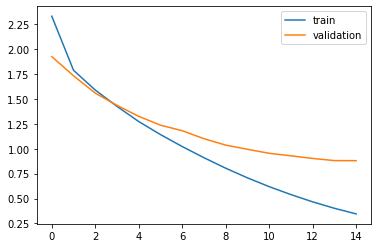

In [27]:
#comparing the training loss an validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

From the graph it is clearly visible that my model is slightly overfit because the validation loss went higher than the training loss after 3rd epoch, it is basically because:
1. The batch size is high.
2. The length for each sentence is kept 8 in both english and french sentences.
3. The learning rate is not optimum.
4. I've taken only 50k records out of 188k rows.



In [28]:
model = load_model('model.h1.24_feb_21')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


These predictions are sequences of numbers, to convert these numbers to corresponding words, we use the function below:

In [36]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

Converting Predictions to English texts:

In [37]:
pred_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_token)
        if j>0 :
            if (t == get_word(i[j-1], eng_token)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t == None):
                temp.append('')
            else:
                temp.append(t) 

    pred_text.append(' '.join(temp))

In [39]:
pred_df = pd.DataFrame({'Actual' : test[:, 0], 'Predicted' : pred_text})
pred_df.head(15)

,Actual,Predicted
0,im glad to hear it,im glad hear that
1,its dead,its is
2,keep climbing,keep climbing
3,i respect you,i will you
4,what did you do then,what do i do
5,ill give you a hint,ill give you a hint
6,have they arrived yet,have they arrived yet
7,she knows everything,she knows everything
8,i hope its true,i hope he was right
9,they robbed me blind,they robbed me blind


The model has done a pretty good job in prediction, the words are being predicted correctly but the problem occurs when the numbers of words in the sentence increase.

I'm currently working to increase the accuracies in longer sentences as well

In [46]:
# preprocessing function
def preprocess(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
    return sentence

# function to get german words using tokens
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

#function to form sentences in deutsch using tokens 
def get_sentence(deu_list):
    final = ''
    for i in deu_list:
        if i != 0:
            word = get_word(i, fre_token)
            final = final + str(word) + ' '
    return final

In [47]:
#function to translate english sentence to deutsch sentence using 
#the functions defined above
def translate(sentence):
    sentence = preprocess(sentence)
    a = encode_sequences(eng_token, eng_length, [sentence])
    b = model.predict_classes(a)[0]
    translation = get_sentence(b)
    return translation

In [56]:
translate('you')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'les ce '